This is the fourth part of a series of notebooks about practical time series methods:
* [Part 1: the basics](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics)
* [Part 2: smoothing methods](https://www.kaggle.com/konradb/practical-time-series-part-2-vintage-methods) 
* [Part 3: ARMA and friends](https://www.kaggle.com/konradb/practical-time-series-pt-3-arma-and-friends) 
* [Part 4: Prophet](https://www.kaggle.com/konradb/practical-time-series-pt-4-prophet) - this notebook

The notebook is split into three sections: we discuss different elements of setting up a Prophet model, show how to evaluate its performance and demonstrate a pipeline putting all the elements together. 

* [Prophet](#section-one)
* [Trend](#section-two)
* [Seasonality](#section-three)
* [Special days](#section-four)
* [Performance evaluation](#section-five)
* [Full pipeline](#section-six)

As before, we begin by importing the required packages

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

import warnings
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

import plotly.graph_objs as go

In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 15
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Prophet

So far, we have discussed two main groups of "vintage" models: exponential smoothing and ARIMA . While fairly easy to setup, they have their challenges:
* exponential smoothing can only handle one seasonal pattern at at time
* ARIMA fails to capture changes in the trend - unless the trend is a monotone polynomial, it is difficult to model accurately within this framework

Challenges like these led to the development of Prophet, which is a time series framework designed to work out of the box. The core idea is based around the structural decomposition:

\begin{equation}
X_t = T_t + S_t + H_t + \epsilon_t
\end{equation}

where
* $T_t$ : trend component
* $S_t$ : seasonal component (weekly, yearly)
* $H_t$ : deterministic irregular component (holidays) -> also outlier
* $\epsilon_t$: noise 

We will discuss the Prophet style of modeling trend, seasonality and holidays in the sections below, but first a crash intro to the theory behind the models. 

## Generalized Additive Models (GAM)

Models like ARIMA rely on correlation between observations from nearby timestamps - an alternative approach is to train the model on overall trends combined with seasonal effects; prediction from such a model is built using combination of smooth functions. Core underlying mathematical result is the Kolmogorov-Arnold representation theorem: multivariate function could be represented as sums and compositions of univariate functions:

\begin{equation} 
    {\displaystyle f({x_1, \ldots, x_n})=\sum _{q=0}^{2n}\Phi _{q}\left(\sum _{p=1}^{n}\phi _{q,p}(x_{p})\right)}
\end{equation}

The theorem has no constructive proof suitable for modeling $\implies$ simplification is necessary: 

\begin{equation}
{\displaystyle f({x_1, \ldots, x_n})=\Phi \left(\sum _{p=1}^{n}\phi _{p}(x_{p})\right)}
\end{equation}
where $\Phi$ is a smooth monotonic function. 

A familiar variant of this approach is the class of Generalized Linear Models :

\begin{equation}
\Phi^{-1}\left[\operatorname {E}(Y)\right]=\beta _{0}+f_{1}(x_{1})+f_{2}(x_{2})+\cdots +f_{m}(x_{m}).\,\!
\end{equation}

The smooth functions in the context of Prophet are the trend, seasonal and holiday components - we can isolate each individual function and evaluate its effect in prediction, which makes such models easier to interpret. we estimate through backfitting algorithm $\rightarrow$ convergence

## The prophetic core

So how does that work in practice? We take a GAM-style decomposition as our starting point:

\begin{equation}
X_t = T(t) + S(t) + H(t) + \epsilon_t
\end{equation}

Unpacking the equation: 

* time is the only regressor

* easy accomodation of new components

* multiple seasonal patterns $\rightarrow$ extension of double exponential smoothing

* forecasting $\rightarrow$ curve fitting

* no need for regular spacing $\implies$ no NA filling

* fast fitting with backfitting algorithm https://en.wikipedia.org/wiki/Backfitting_algorithm

* probabilistic aspects - Hamiltonian Monte Carlo (which is why Windows have an extra step of Stan installation - but trust me, it's worth it)

* works in more general cases, but "designed" for daily data



Below we discuss each of the components in its own section.

<a id="section-two"></a>
# Trend model

The Prophet library implements two possible trend models.


## Linear Trend

The first, default trend model is a simple Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

\begin{equation}
T(t) = \left[k + a(t)^T \delta \right]t + \left[m + a(t)^T \gamma\right]
\end{equation}

By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.


We demonstrate this functionality by using New York Times data on Covid cases: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv

<AxesSubplot:>

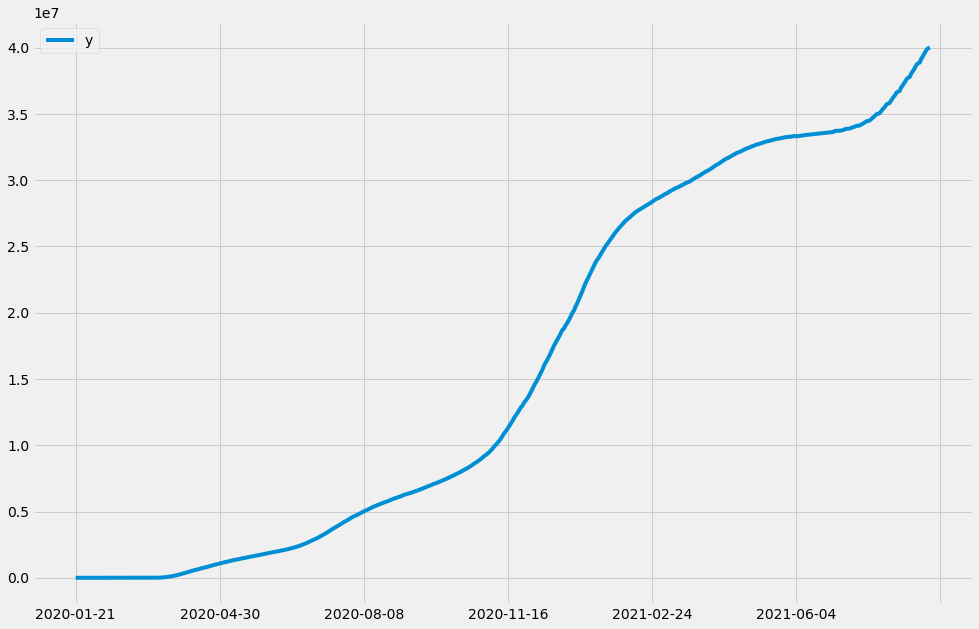

In [3]:
df = pd.read_csv(CFG.data_folder + 'us_covid.csv')
df.head(10)


# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

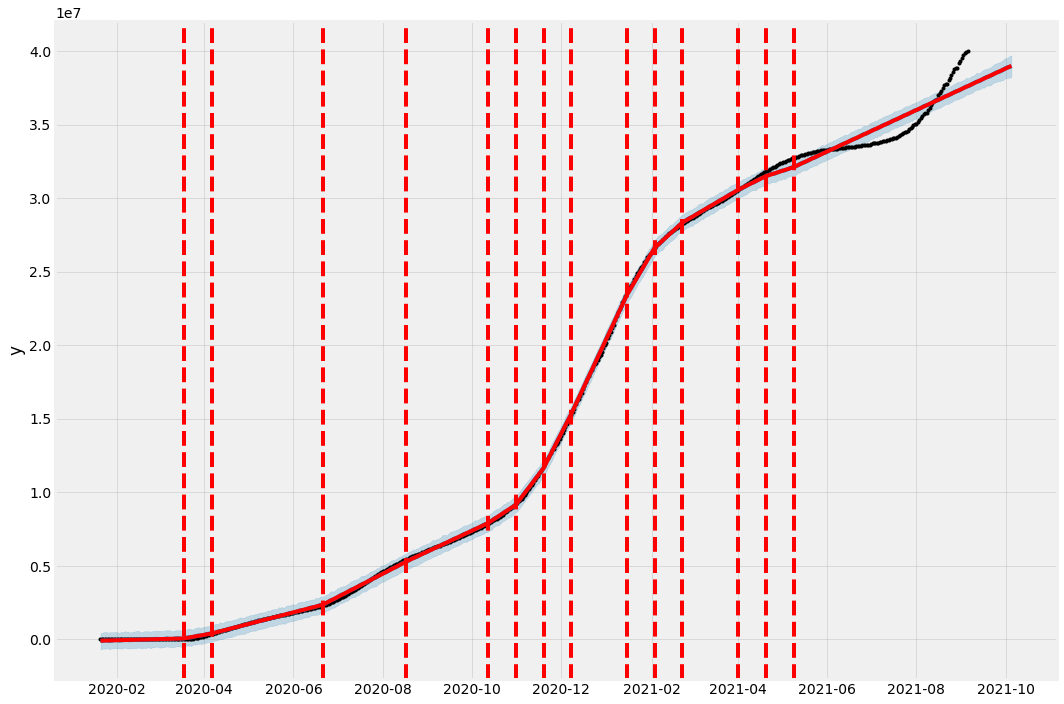

In [4]:
# automatic detection of changepoints
m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

It seems like the default settings are on the generous side when it comes to assigning changepoints - we can control this behavior by enforcing more regularization. This is achieved by shrinking the `changepoint_prior_scale` parameter:

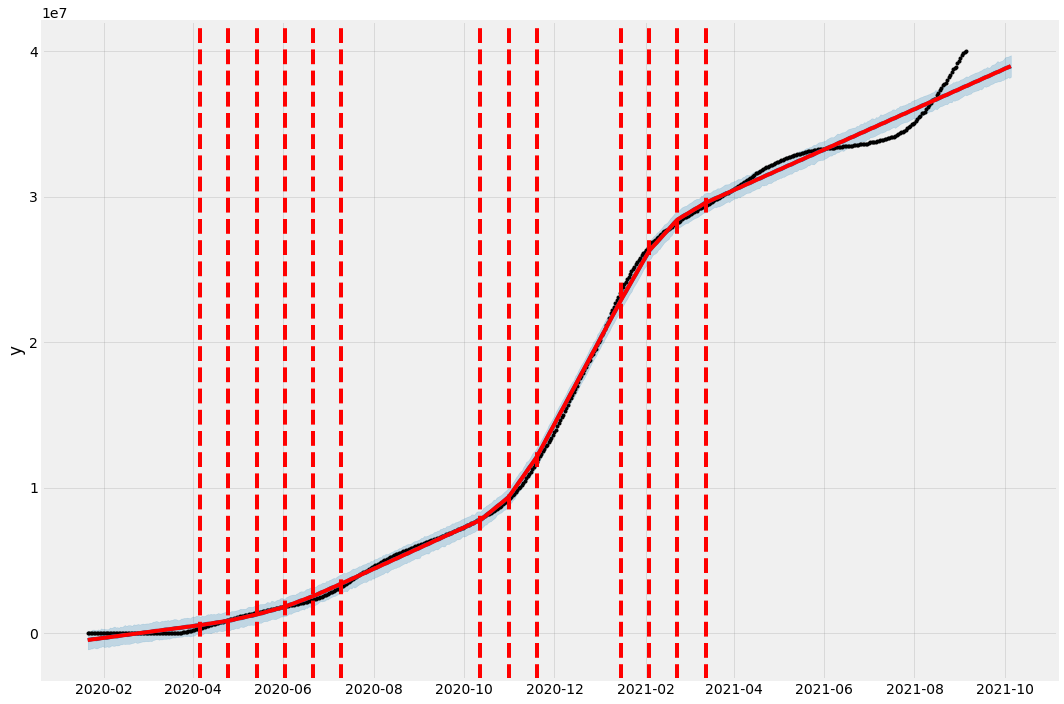

In [5]:
m = Prophet(changepoint_prior_scale = 0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Nonlinear growth 

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:
    
\begin{equation}
T(t) = \frac{C}{1 + exp(-k(t-m))}
\end{equation}

where $C$ is the carrying capacity (maximum value) and $k$ is the growth rate ("steepness" of the trend curve). $C$ and $k$ can be constant or time-varying. This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data.

Sticking with the theme that has dominated everybody's life from 2020, we will use data on Covid-19 cases in China.

<AxesSubplot:>

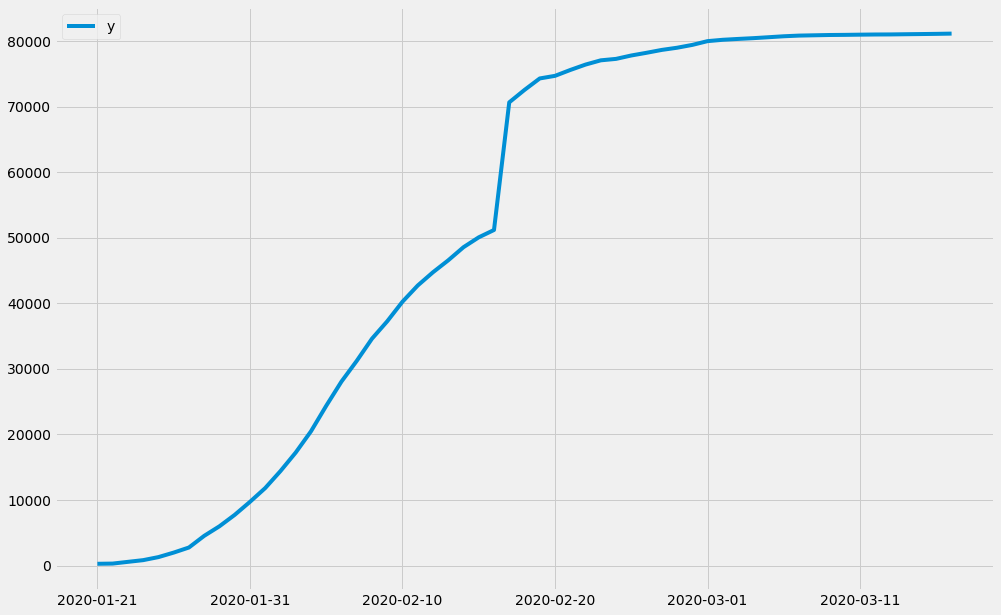

In [6]:
df = pd.read_csv('../input/who-cases-dataset-and-wdi-country-population/WHO_full_data2003.csv')
# subset the data and rename the columns to Prophet naming convention
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

We can see the curve flatlining somewhat - in Prophet we can incorporate such knowledge into the model by setting a cap (an upper limit on the forecast value):

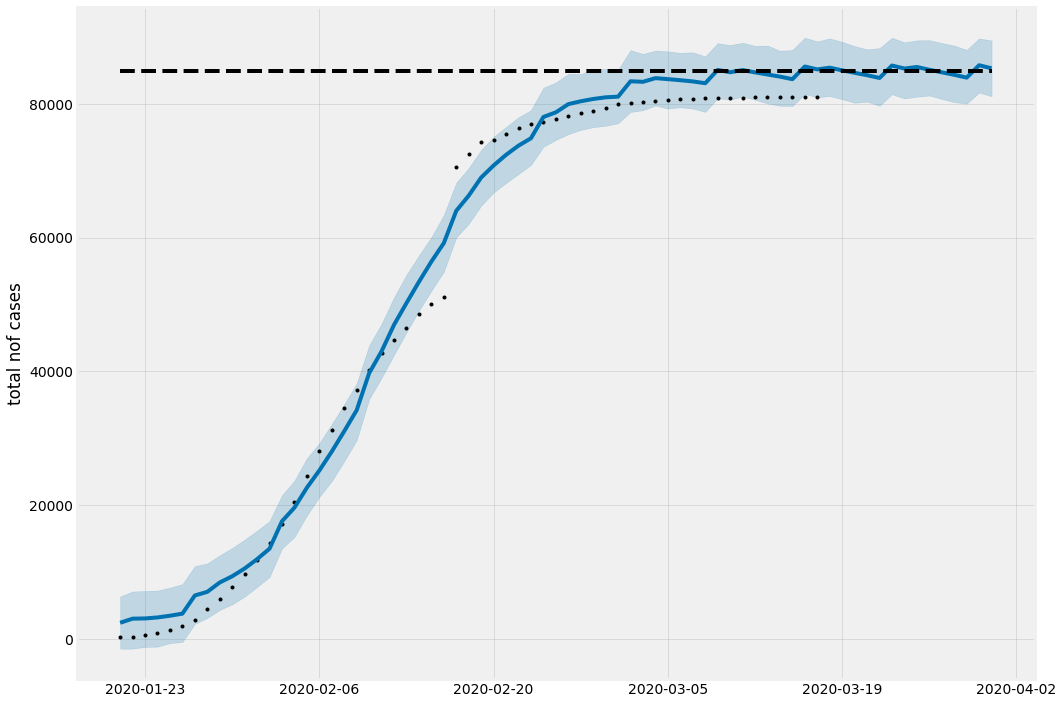

In [7]:
# add the cap to the 
df['cap'] = 85000
# fit the model
m = Prophet(growth='logistic')
m.fit(df)
# prediction
future = m.make_future_dataframe(periods= 14)
future['cap'] = 85000

# plot the results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')

The approach is symmetrics, i.e. we can limit the series from below as well (contrived as it might seem in this particular application ;-) 

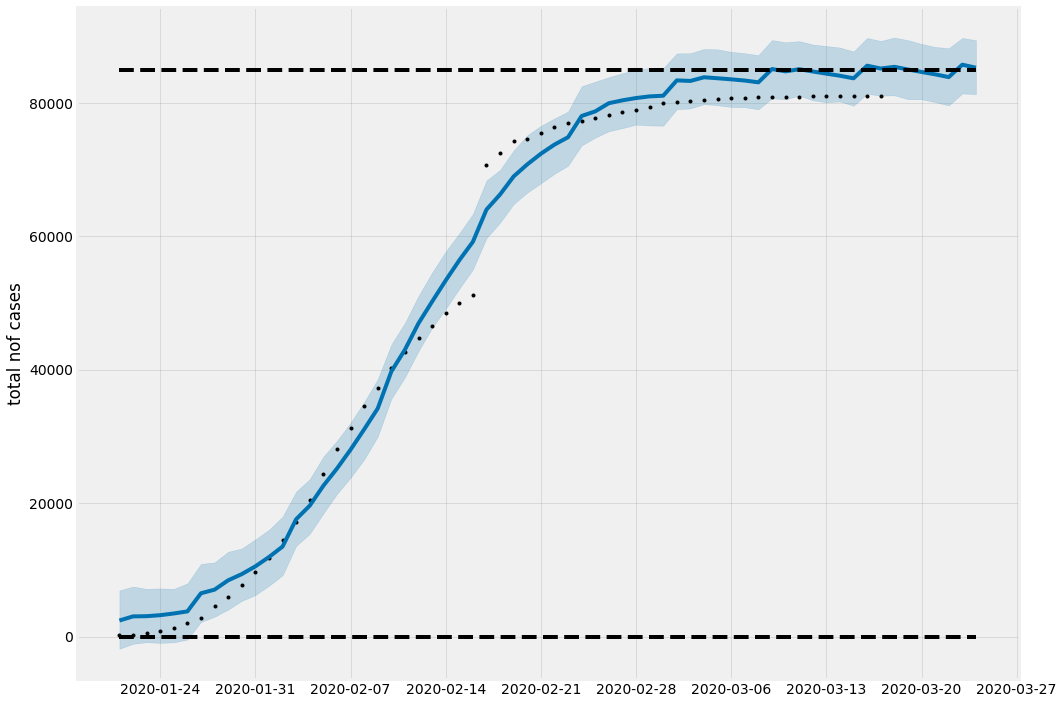

In [8]:
# set the upper & lower limit for the forecast
df['cap'] = 85000
df['floor'] = 0

# fit a model
m = Prophet(growth='logistic')
m.fit(df)

# predict
future = m.make_future_dataframe(periods= 7)
future['cap'] = 85000
future['floor'] = 0
fcst = m.predict(future)

m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

<a id="section-three"></a>
# Seasonality

When dealing with data in practical applications, it is frequently necessary to take into account multiple seasonal patterns occurring in parallel; a classic example would be data related to energy consumption: there are morning vs evening patterns (intraday), workdays vs weekend (weekly) and during the year (annual). Modeling them explicitly is not possible in the ARIMA framework and cumbersome within the state space framework, which is one of the issues Prophet was designed to overcome. The core of the underlying logic is a the Fourier expansion:
    
\begin{equation}
    S(t) = \sum_{i=1}^N \left(a_n cos\left(\frac{2\pi i t}{P} \right) + b_n sin\left(\frac{2 \pi i t}{P} \right) \right)
\end{equation}

Unpacking this formula: 

* `sin` and `cos` function form an orthogonal basis https://en.wikipedia.org/wiki/Orthogonal_functions#Trigonometric_functions
* this means that every function can be represented as a combination as in the equation defined above - recall that in the GAM setup we treat time as the only regressor, so a time series can be viewed as a function of time $S(t)$ 
* by cutting off the expansion for a certain $N$ we can remove high frequency oscillations $\rightarrow$ low pass filter

## Frequency shenanigans

Let us briefly explore how you can specify different seasonality patterns: we will use the energy consumption data from PJM Interconnection LLC (PJM) - a regional transmission organization (RTO) in the United States. The data is available on Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption.

In [9]:
df = pd.read_csv('../input/hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head(5)

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


Prophet is built for univariate data, so we will pick one series. Notice that we are using hourly data, which we will progressively aggregate to lower frequencies to demonstrate the out-of-the-box functionality that Prophet provides.

<AxesSubplot:xlabel='ds'>

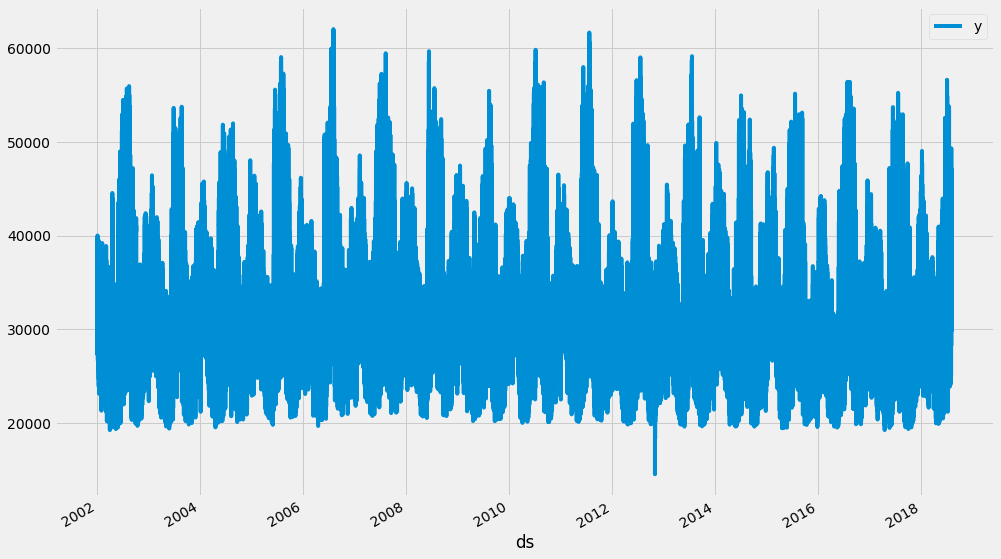

In [10]:
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

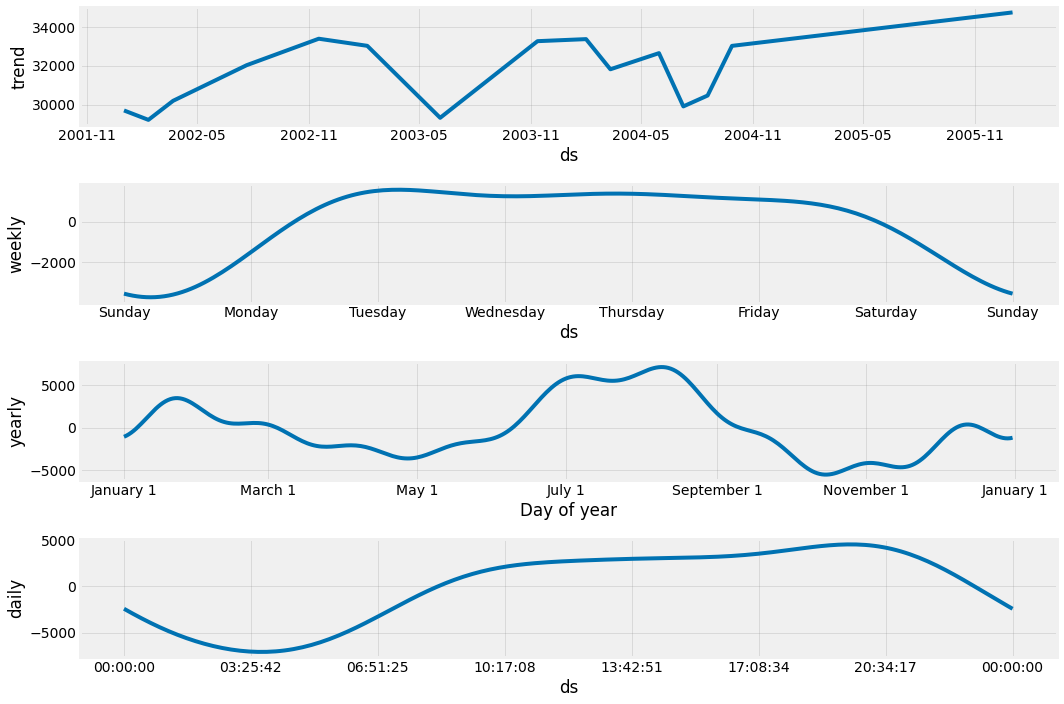

In [11]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles 
# for each seasonality we intend to fit 
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

If we are using data sampled at higher frequency than daily, a daily seasonal pattern is automatically fitted. What if we aggregate the data to daily frequency?

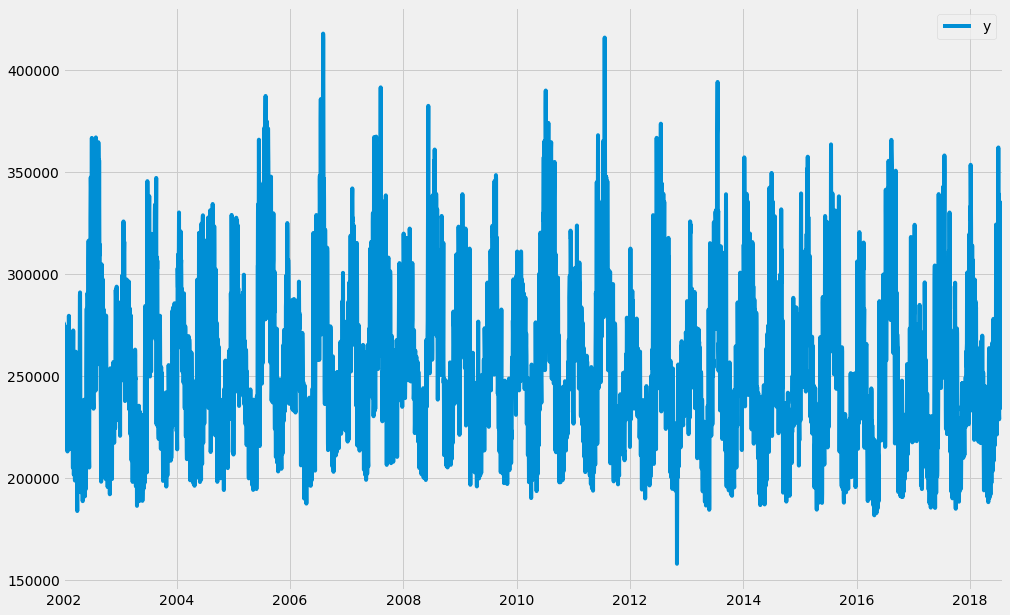

In [12]:
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

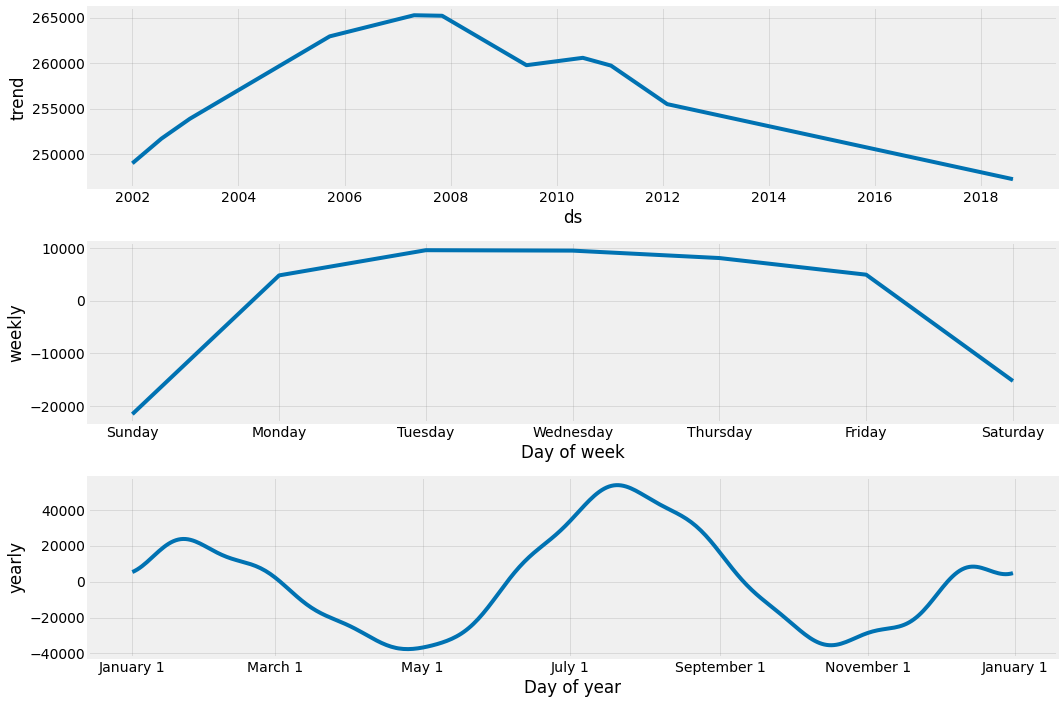

In [13]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

The same logic applies if we downsample the data further:

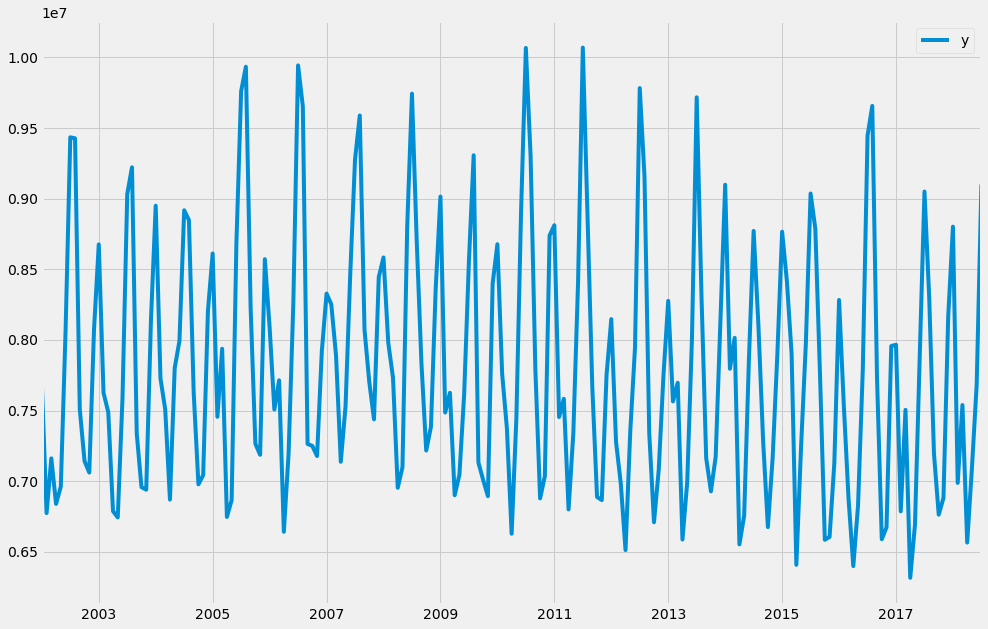

In [14]:
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

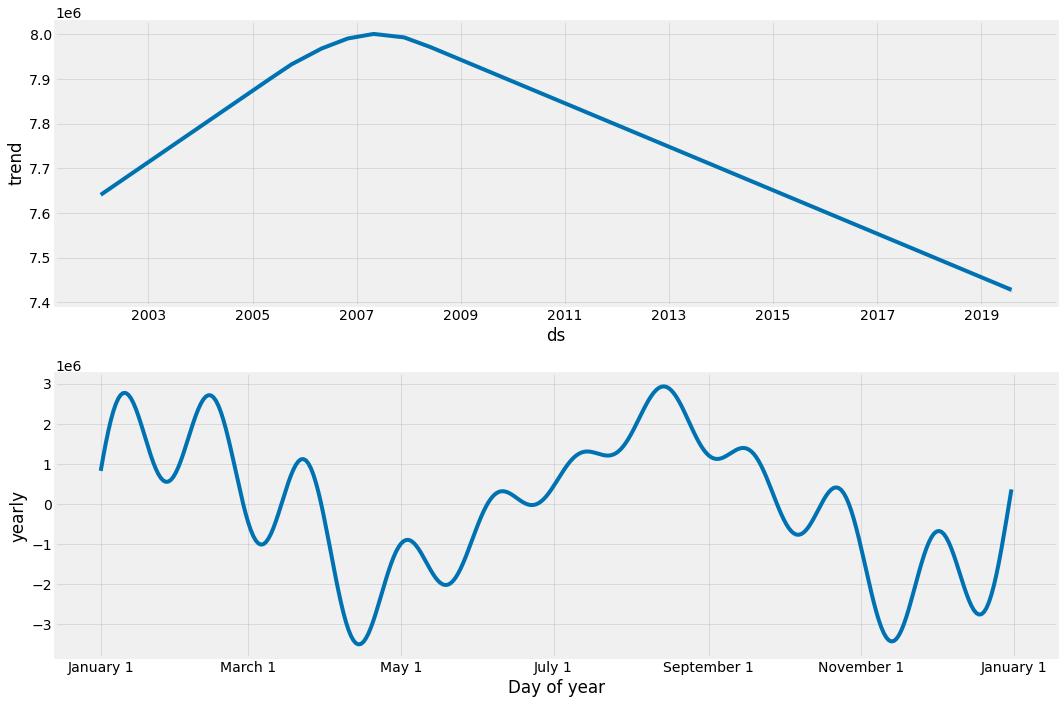

In [15]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

## Seasonality specification

Apart from deciding on which frequencies to model explicitly, we have more options to setup our Prophet model. First, there is `seasonality_mode` - additive or multiplicative:

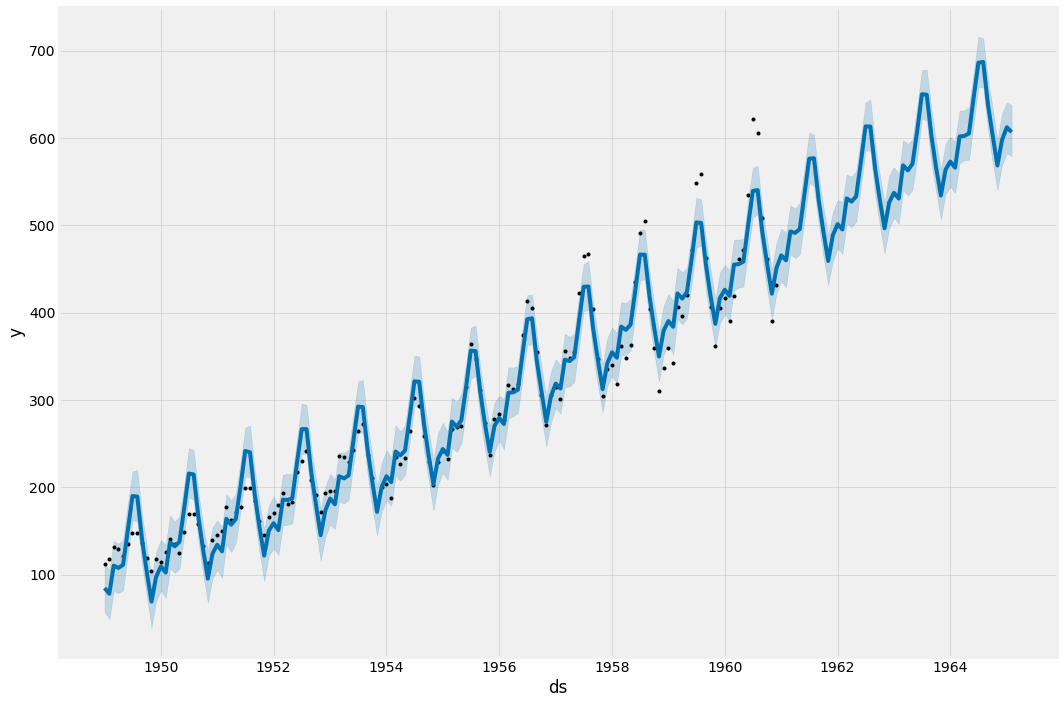

In [16]:
# import inspect ; xlist = inspect.getfullargspec(Prophet); xlist.args
df = pd.read_csv(CFG.data_folder + 'example_air_passengers.csv')
m = Prophet(seasonality_mode ='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

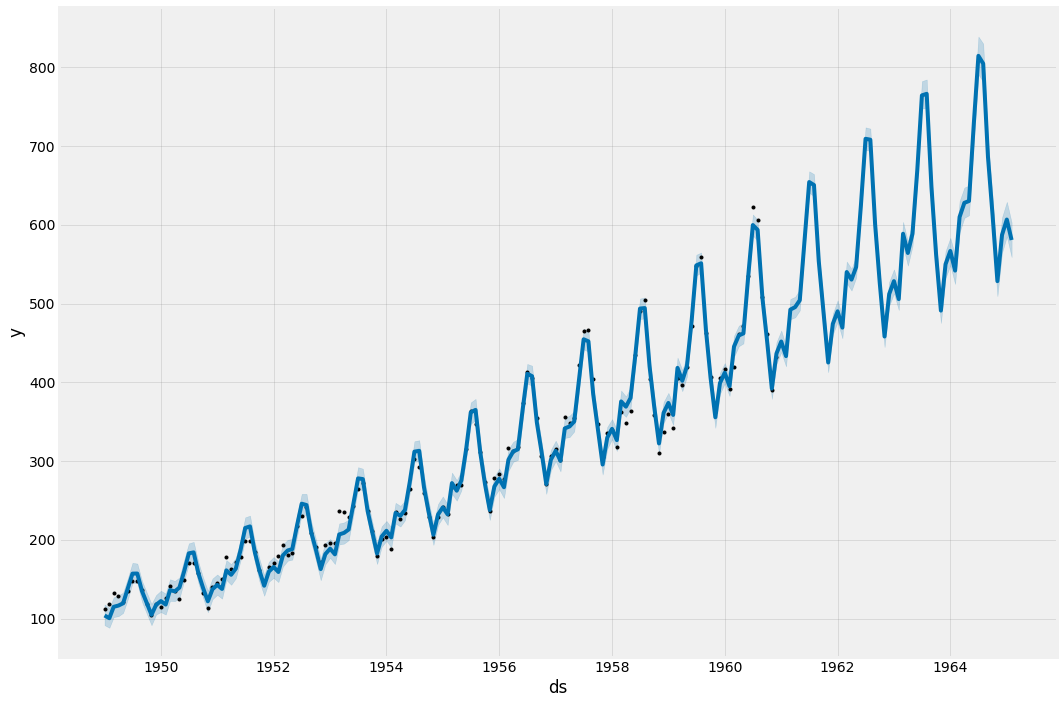

In [17]:
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Depending on the problem at hand, we might want to allow strong effects of the seasonal component on the forecast - or have it reduced. This intuition can be quantified by adjusting the `seasonality_prior_scale` argument, which imapcts the extent to which the seasonality model will fit the data (remark for those with Bayesian exposure: works pretty much the way a prior would).

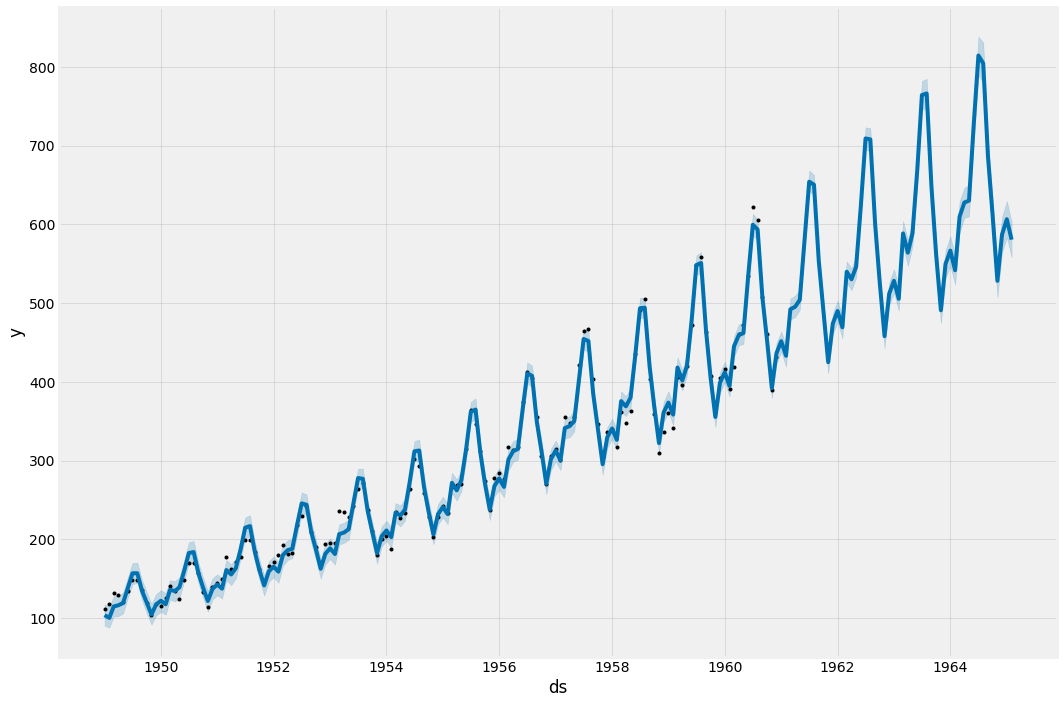

In [18]:
# we keep the default value
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

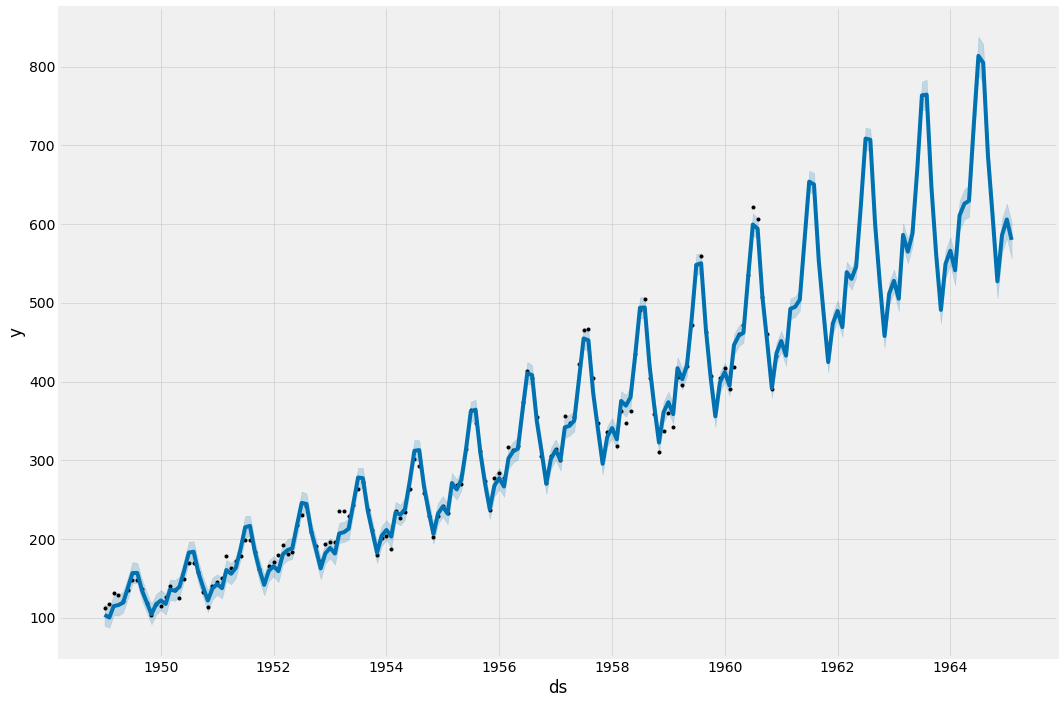

In [19]:
# we reduce the seasonality prior
m = Prophet(seasonality_mode ='multiplicative', seasonality_prior_scale = 1)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Last but not least, we can - as we usually ought to - use interval forecast, i.e. have our point estimates combined with uncertainty. By default the parameter `mcmc_samples` is set to 0, so to get the interval around seasonality, you must do full Bayesian sampling.

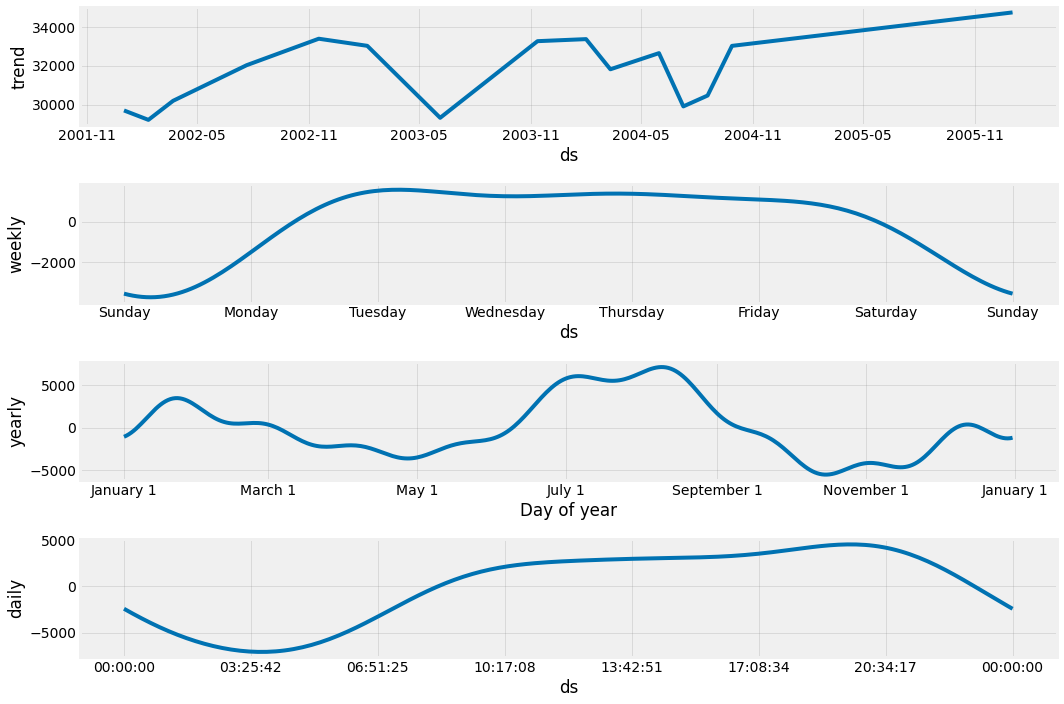

In [20]:
df = pd.read_csv('../input/hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
# xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()


What if we switch to Bayesian inference (change `mcmc_samples` to a positive integer)?

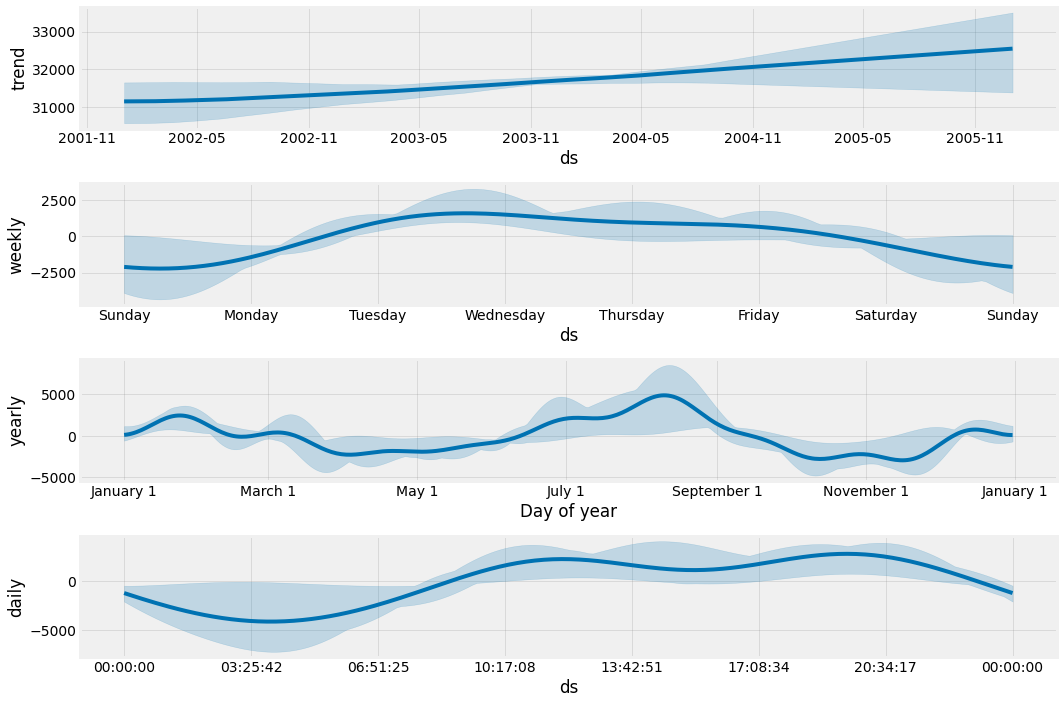

In [21]:
m = Prophet(mcmc_samples = 10).fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

Keep in mind that although PyStan https://pystan.readthedocs.io/en/latest/ is SOTA for MCMC sampling, it still takes some time - in particular, for long time series. 

<a id="section-four"></a>
# Special days

So we have handled trend and seasonality - but that does not mean everything else belongs with the random error component. There are data points that are not random per se, but can still have impact on the performance of the model:

* public holidays (Christmas, Easter, New Year, Black Friday)
* special events (World Cup) 
* major events like conflict starting or terrorist attacks - when analyzing historical performance of the model, it is frequently useful to remove those
* outliers - this is something of a catch-all category, but frequently possible to identify by inspecting the data. 

The Prophet approach to modeling abnormal days is to provide a custom list of events. We assume the effects are independent, so if e.g. a sports event occurs near public holiday, their effects will be captured separately.

## Holidays

The dataset we will use to test the Prophet functionality around special days is daily count of bike commuters in Oslo https://www.kaggle.com/konradb/norway-bicycles

In [22]:
bikerides = pd.read_csv('../input/norway-bicycles/bikerides_day.csv', error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
bikerides.head(5)
# the usual formatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

We start with the fast and easy way of adding holidays: using the built-in list of country holidays:

In [23]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

I don't speak Norwegian, but a quick visit to Google Translate shows that Christmas is missing - which, in Europe, is typically a rather important public holiday. We will take care of adding it later, for now let's see how well the model is doing out of the box:

In [24]:
# as before, we create a dataframe holding the dates for the entire forecast horizon - 180 days ahead
future = m.make_future_dataframe(periods=180, freq='D')
# generate the actual forecast 
forecast = m.predict(future)

fig = go.Figure()
# full disclosure: I am changing the plotting style for this one, because I don't know how to overlay the two graphs with the baseline Prophet plotting functionality that served us well up to that point (not to mention the cool functionality of panning/scaling the graph ;-)

fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

Overall the forecast seems directionally ok - but if we zoom a little closer, there are issues:

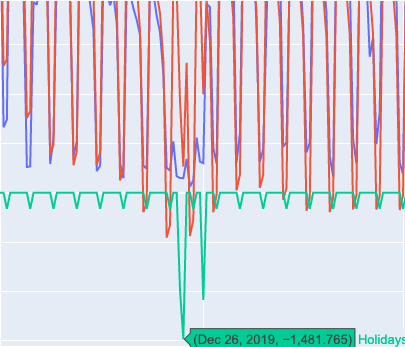

Let's see if we can improve by augmenting the list of holidays: we do that by creating a new dataframe `christmas`, which is subsequently passed as an argument to Prophet. The 'holiday' entry is mostly for interpretation sake, relevant parts are:
* `ds` - so we know when the holiday of interest occurs
* `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below `lower_window` equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas `upper_window` is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week. 


In [25]:
christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})


m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()


This does look better:

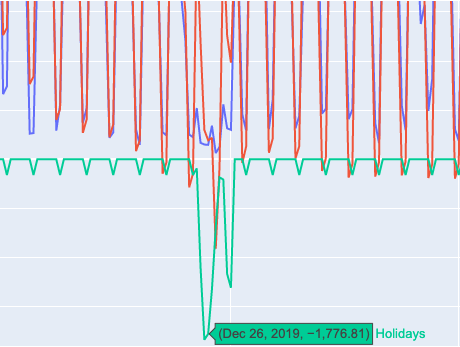

## Outliers

We can use the built-in Prophet functionality to deal with outliers - for the sake of clarity of exposition, we will re-use the example used also in the official documentation, i.e. log of daily count of visits to the Wikipedia page of R language.

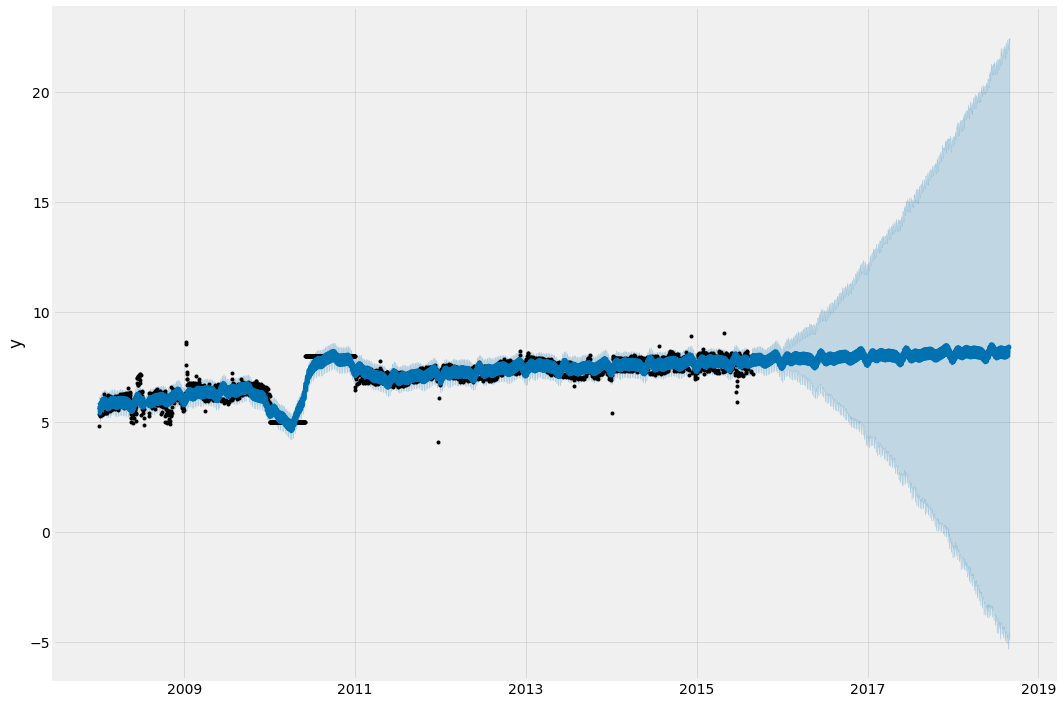

In [26]:
df = pd.read_csv(CFG.data_folder + 'example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

The pattern in 2011 does not look plausible (flat line, jump, flat line at a higher level), and those observations are the most likely culprit for the misspecified trend and the resulting bredth of the confidence bands. Prophet allows us to deal with the problem in a very straightforward manner, i.e. by replacing the dubious observations with `None` (not `NaN` - it is an important distinction to keep in mind).

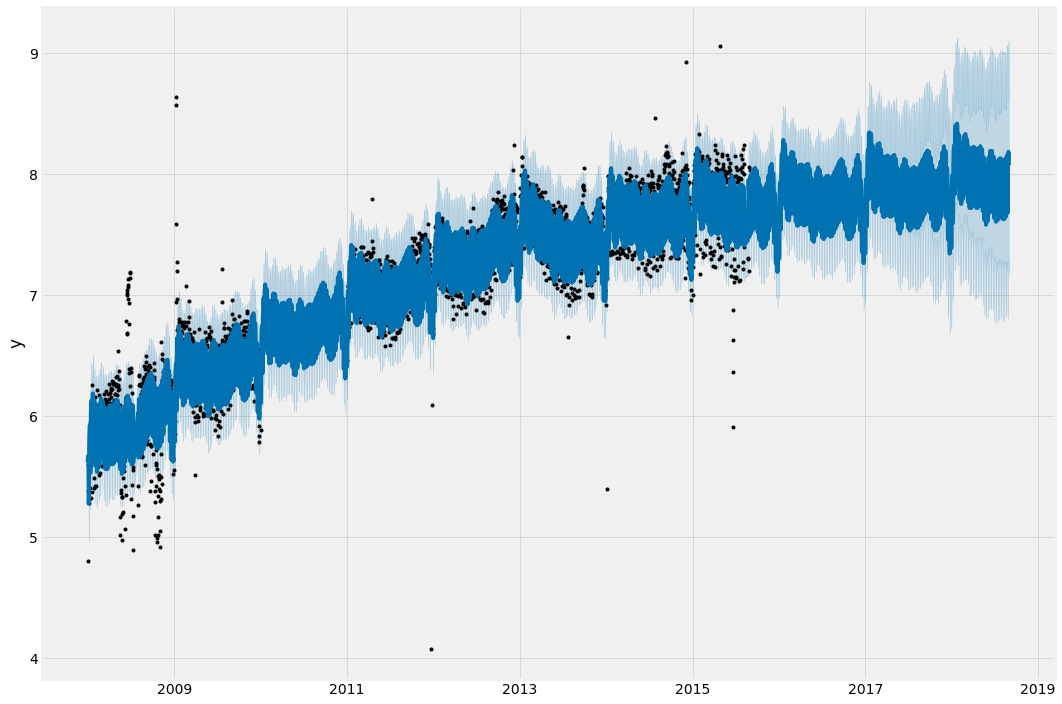

In [27]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future), figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

Another type of situation we may encounter is a few points whose values are extremely off, so as a result the seasonality estimate is impacted.

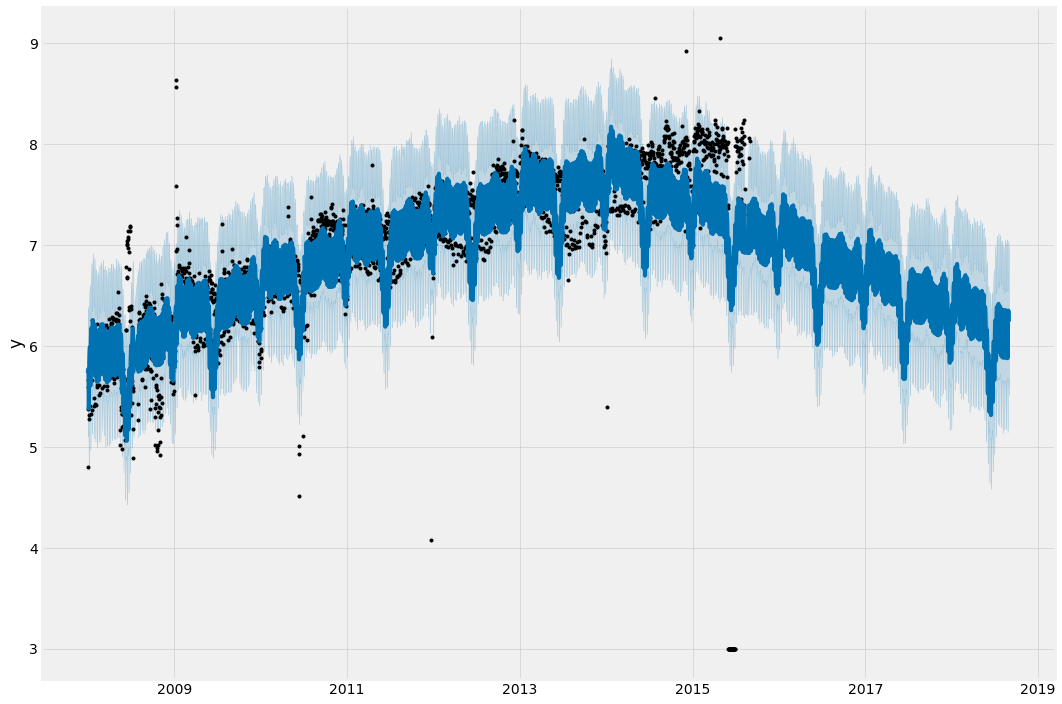

In [28]:
df = pd.read_csv(CFG.data_folder + 'example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

As before, the simplest solution is to get rid of those points and leave the algorithm to interpolate within the sample:

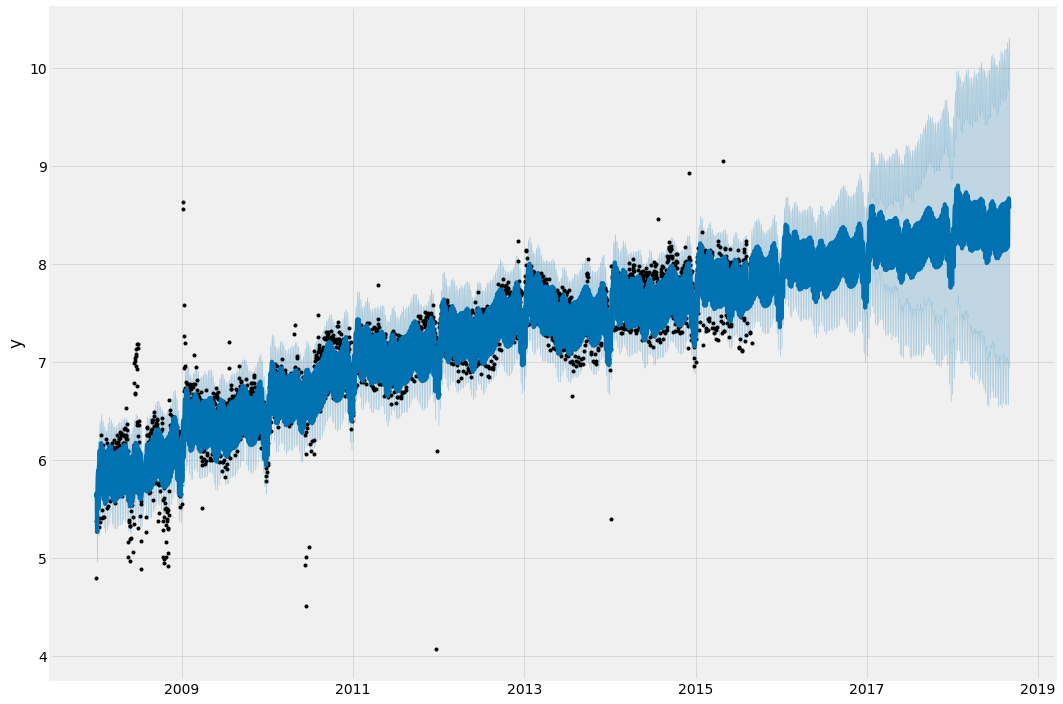

In [29]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

To summarize: leveraging the Prophet functionality around in-sample interpolation, we can solve issues related to outliers by simply replacing them with `None`s.

<a id="section-five"></a>
# Performance evaluation

Cross validation for time series can be sometimes challenging, but the Prophet approach takes the hassle out of having to create your own function for a rolling forecast. We utilize the `cross_validation` function: the parameters to specify are the forecast horizon `horizon` and (optionally) size of the initial training period `initial` and the spacing between cutoff dates `period`. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

       

In [30]:
df_cv = cross_validation(m, initial = '1000 days', period = '30 days', horizon='30 days')


  0%|          | 0/59 [00:00<?, ?it/s]

The output of cross_validation is a dataframe where for $cutoff$ (last timepoint in the training set) we get a number of values:
* $ds$ is the timepoint in test set
* $y$ is the true value at $ds$
* $yhat\_lower$ and $yhat\_upper$ are the lower and upper ends of the condifence interval, respectively


In [31]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-10-27,7.043898,6.693693,7.414537,7.370860,2010-10-26
1,2010-10-28,7.040077,6.682711,7.378480,7.407318,2010-10-26
2,2010-10-29,6.954792,6.581431,7.289344,7.237778,2010-10-26
3,2010-10-30,6.610974,6.260702,6.949566,6.742881,2010-10-26
4,2010-10-31,6.594863,6.208479,6.926241,6.884487,2010-10-26
5,2010-11-01,6.988195,6.657866,7.354655,7.235619,2010-10-26
6,2010-11-02,7.074142,6.711923,7.401700,7.195937,2010-10-26
7,2010-11-03,7.110214,6.748376,7.483629,7.145984,2010-10-26
8,2010-11-04,7.121056,6.783251,7.472894,7.313887,2010-10-26
9,2010-11-05,7.050105,6.693784,7.395663,7.187657,2010-10-26


While informative, the object created with `cross_validation` contains an abundance of information. This can be summarized in a more succinct manner by aggregating to yield performance metrics:

In [32]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.095431,0.308920,0.168699,0.024444,0.017776,0.895543
1,4 days,0.095225,0.308586,0.169153,0.024432,0.017515,0.889595
2,5 days,0.084354,0.290438,0.160576,0.023417,0.017320,0.912281
3,6 days,0.037883,0.194636,0.146926,0.019825,0.016139,0.895250
4,7 days,0.037273,0.193063,0.147530,0.019997,0.015737,0.918744


The values from the `cross_validation` objects are aggregated for each horizon and different metrics are calculated.


<a id="section-six"></a>
# Full pipeline

We are in a position to combine all the building block - we will revisit the Superstore dataset (a version can be found here: https://www.kaggle.com/bravehart101/sample-supermarket-dataset), previously used in [Module 3](https://www.kaggle.com/konradb/practical-time-series-pt-3-arma-and-friends).


In [33]:
!pip install xlrd

     |████████████████████████████████| 96 kB 951 kB/s 


In [34]:
# We use the same code as before to perform the aggregation and cleanup - check the previous module for a step-by-step
df = pd.read_excel(CFG.data_folder + "Sample - Superstore.xls")
df = df.loc[df['Category'] == 'Furniture']
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')
df = df.groupby('Order Date')['Sales'].sum().reset_index()

# Prophet-friendly format
df.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace = True)

In the previous module we aggregated the dataset to monthly frequency - some observations were missing and ARIMA does not have a straightforward method of dealing with that (interpolation in time series is a serious topic, deserving its own module probably). Prophet does not suffer from the same limitation, so we stay at daily frequency. 

What does our series look like?


<AxesSubplot:>

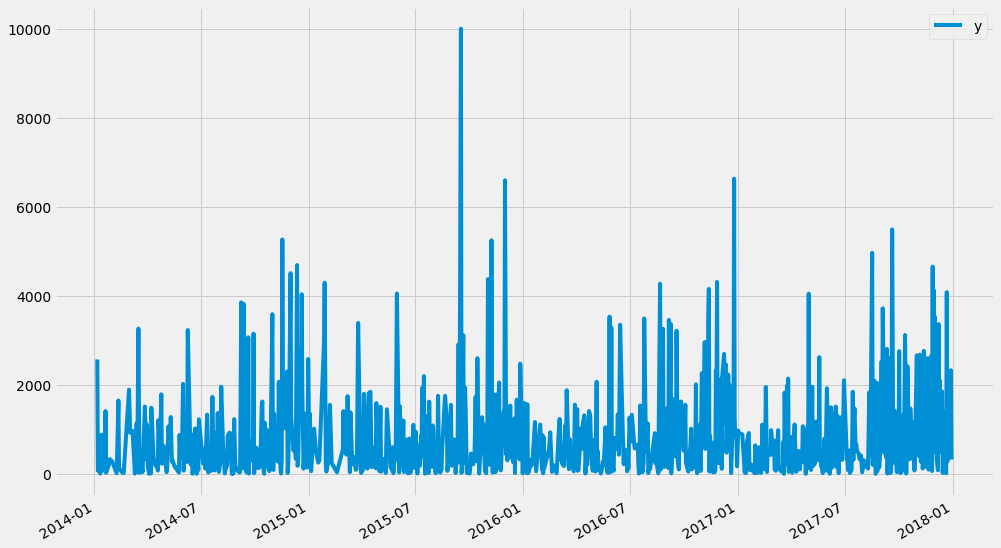

In [35]:
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')


What is the time range we are dealing with?

In [36]:
min(df['ds']), max(df['ds'])

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

With four complete cycles present, we can keep the last three months of 2017 as validation and use the rest of the data for training:

In [37]:
df_train = df.loc[df['ds'] < '2017-10-01']
df_valid = df.loc[df['ds'] >= '2017-10-01']
print(df_train.shape, df_valid.shape)

(810, 2) (79, 2)


Next step is specifying the form of our model - we can combine this step with hyperparameter tuning. In order to keep the running time of this notebook within reasonable limits, the possible parameter ranges to a bare minimum needed to demonstrate the functionality (in a real application the only real limit is your patience).

In [38]:
param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
#    'seasonality_prior_scale': [0.01, 1.0],
#    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

# Quick peek at what our combinations look like
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [39]:
for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial = '100 days', period = '30 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

   changepoint_prior_scale seasonality_mode         rmse
0                    0.001         additive  8545.619231
1                    0.001   multiplicative  2539.010606
2                    0.100         additive  3882.768074
3                    0.100   multiplicative  2112.955185
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


With the tuned parameters available we can proceed to setup the complete model - as mentioned before, the parameters can included in the tuning part can be left at default values (`auto` for `yearly_seasonality` is automatically set to `True` if there are multiple years in the data etc):

In [40]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')
m.fit(df_train)

Model component inspection:

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



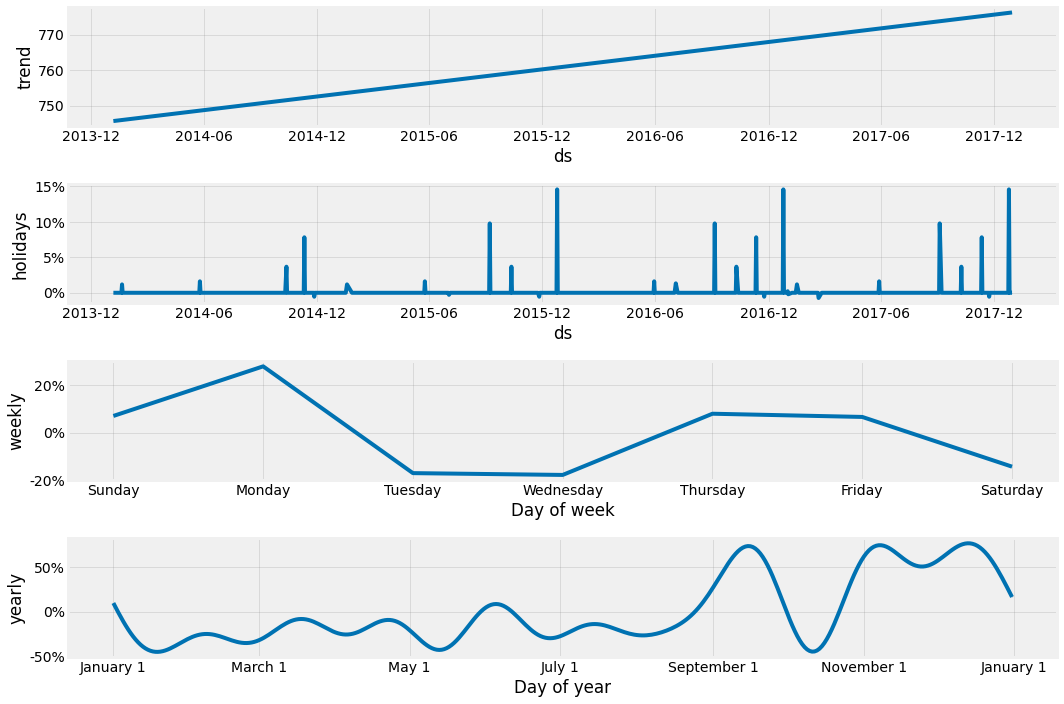

In [41]:
future = m.make_future_dataframe(periods = 92, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

By default, the `forecast` dataframe contains an abundance of information, including point/upper/lower estimates of the contribution made to the forecast by the trend component, different seasonalities and each holiday defined in the model:

In [42]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

While interesting if you want to examine every component in detail, for this example we will focus on the point forecast and the associated confidence band:

In [43]:
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2017-10-01' ]
xfor.head(10)

,ds,yhat,yhat_upper,yhat_lower
811,2017-10-01,812.671120,2021.177767,-415.521617
812,2017-10-02,921.886930,2069.777183,-398.243573
813,2017-10-03,522.026949,1717.574629,-604.579248
814,2017-10-04,469.094054,1704.355425,-731.687437
815,2017-10-05,626.556709,1838.957696,-622.961809
816,2017-10-06,578.140940,1865.011376,-570.428393
817,2017-10-07,383.105612,1566.878075,-961.614464
818,2017-10-08,522.740225,1688.986567,-770.176634
819,2017-10-09,693.804209,1839.687015,-438.393256
820,2017-10-10,302.930461,1530.277659,-972.623734


In [44]:
# we combine the forecast dataframe with the original test data
# we use a left outer join because of the missing observations in the original data
xfor = pd.merge(left = xfor, right = df, on = 'ds', how = 'left')


In [45]:
xfor.head(10)

,ds,yhat,yhat_upper,yhat_lower,y
0,2017-10-01,812.671120,2021.177767,-415.521617,559.760
1,2017-10-02,921.886930,2069.777183,-398.243573,2758.464
2,2017-10-03,522.026949,1717.574629,-604.579248,255.208
3,2017-10-04,469.094054,1704.355425,-731.687437,19.980
4,2017-10-05,626.556709,1838.957696,-622.961809,935.802
5,2017-10-06,578.140940,1865.011376,-570.428393,41.960
6,2017-10-07,383.105612,1566.878075,-961.614464,462.430
7,2017-10-08,522.740225,1688.986567,-770.176634,145.764
8,2017-10-09,693.804209,1839.687015,-438.393256,1333.393
9,2017-10-10,302.930461,1530.277659,-972.623734,239.358


<AxesSubplot:>

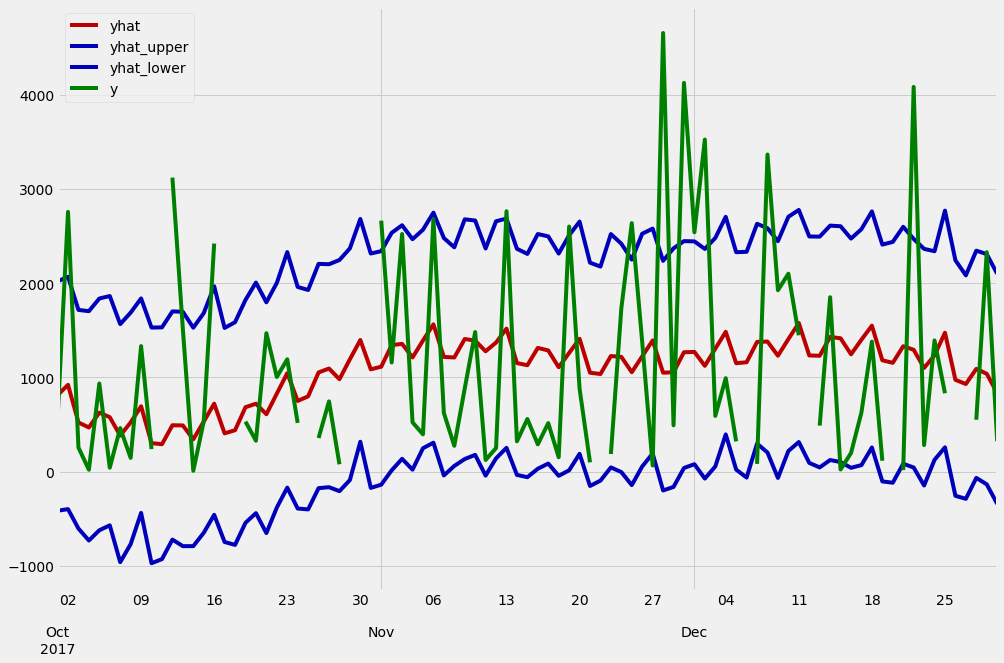

In [46]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']

xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')


While there is definitely space for improvement - the model does not capture the magnitude of the variations, and the associated confidence interval is rather broad - this example demonstrates that with minimal effort, we can use Prophet to model time series in a fast and intrepretable manner.